# KEGG enrichment of stable genes

This notebooks looks at the group of most and least stable genes and performs a KEGG enrichment analysis to determine if there are any KEGG pathways that are significantly over-represented in our most or least stable gene sets.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.stats.multitest
from scripts import paths, utils, annotations

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Load KEGG pathway data
pao1_pathway_filename = "https://raw.githubusercontent.com/greenelab/adage/7a4eda39d360b224268921dc1f2c14b32788ab16/Node_interpretation/pseudomonas_KEGG_terms.txt"

In [3]:
pao1_pathways = annotations.load_format_KEGG(pao1_pathway_filename)
print(pao1_pathways.shape)
pao1_pathways.head()

(169, 2)


,1,2
0,,
KEGG-Pathway-pae00072: Synthesis and degradation of ketone bodies,10,"{PA2011, PA1999, PA3925, PA1736, PA2000, PA358..."
KEGG-Pathway-pae00071: Fatty acid degradation,32,"{PA1748, PA3013, PA1736, PA5427, PA0447, PA281..."
KEGG-Pathway-pae00903: Limonene and pinene degradation,9,"{PA1821, PA3331, PA1748, PA1027, PA4899, PA173..."
KEGG-Pathway-pae00380: Tryptophan metabolism,27,"{PA0704, PA1748, PA1736, PA2579, PA0447, PA208..."
KEGG-Pathway-pae00900: Terpenoid backbone biosynthesis,16,"{PA4785, PA3925, PA4569, PA4043, PA1736, PA358..."


In [4]:
# Load transcriptional similarity df
# These are the subset of genes that we will consider
pao1_similarity_scores_filename = "pao1_similarity_scores_spell.tsv"

pao1_similarity_scores = pd.read_csv(
    pao1_similarity_scores_filename, sep="\t", header=0, index_col=0
)

In [5]:
pao1_similarity_scores.head()

,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,
PA1094,PA14_50270,0.326832,2.285473e-133,fliD,NaN
PA0935,PA14_52160,0.391218,3.722000e-195,NaN,NaN
PA4751,PA14_62860,0.509608,0.000000e+00,ftsH,NaN
PA3895,PA14_13510,0.299470,2.903470e-111,NaN,NaN
PA4769,PA14_63070,0.289410,1.022809e-103,NaN,NaN


In [6]:
# Get most and least stable core genes based on label
pao1_most_stable_genes = list(
    pao1_similarity_scores[pao1_similarity_scores["label"] == "most stable"].index
)
pao1_least_stable_genes = list(
    pao1_similarity_scores[pao1_similarity_scores["label"] == "least stable"].index
)

In [7]:
# For each KEGG pathway, perform stat test, save p-values to get corrected p-values, report stats per pathway
def KEGG_enrichment_of_stable_genes(similarity_score_df, gene_list, kegg_df):
    """
    This function performs a KEGG enrichment using most or least stable genes,
    provided in `gene_list`
    """

    all_genes = set(similarity_score_df.index)
    module_genes = set(gene_list)
    not_module_genes = all_genes.difference(module_genes)

    rows = []
    # Find the KEGG pathway with significant over-representation
    for kegg_name in kegg_df.index:
        num_kegg_genes = kegg_df.loc[kegg_name, 1]
        kegg_genes = set(kegg_df.loc[kegg_name, 2])
        not_kegg_genes = all_genes.difference(kegg_genes)

        # Make contingency table
        # ---------------------| most stable  | not most stable
        # in KEGG pathway      | # genes      | # genes
        # not in KEGG pathway  | # genes     | # genes
        module_kegg_genes = module_genes.intersection(kegg_genes)
        not_module_kegg_genes = not_module_genes.intersection(kegg_genes)
        module_not_kegg_genes = module_genes.intersection(not_kegg_genes)
        not_module_not_kegg_genes = not_module_genes.intersection(not_kegg_genes)

        observed_contingency_table = np.array(
            [
                [len(module_kegg_genes), len(not_module_kegg_genes)],
                [len(module_not_kegg_genes), len(not_module_not_kegg_genes)],
            ]
        )
        # Fisher's exact test
        oddsr, pval = scipy.stats.fisher_exact(
            observed_contingency_table, alternative="greater"
        )
        # chi2 test will not accept 0 counts for the contingency table
        # chi2, pval, dof, expected_counts = scipy.stats.chi2_contingency(
        #    observed_contingency_table
        # )
        # print(oddsr, pval)

        rows.append(
            {
                "enriched KEGG pathway": kegg_name,
                "odds ratio": oddsr,
                "p-value": pval,
                "num shared genes": len(module_kegg_genes),
                "size gene set": len(module_genes),
                "size KEGG pathway": num_kegg_genes,
            }
        )

    enrichment_df = pd.DataFrame(rows)

    # Get corrected pvalues
    (
        reject_,
        pvals_corrected_,
        alphacSidak,
        alphacBonf,
    ) = statsmodels.stats.multitest.multipletests(
        enrichment_df["p-value"].values,
        alpha=0.05,
        method="fdr_bh",
        is_sorted=False,
    )

    enrichment_df["corrected p-value"] = pvals_corrected_

    return enrichment_df

In [8]:
pao1_most_stable_enrichment = KEGG_enrichment_of_stable_genes(
    pao1_similarity_scores, pao1_most_stable_genes, pao1_pathways
)

In [9]:
pao1_least_stable_enrichment = KEGG_enrichment_of_stable_genes(
    pao1_similarity_scores, pao1_least_stable_genes, pao1_pathways
)

In [10]:
print(pao1_most_stable_enrichment.shape)
pao1_most_stable_enrichment.sort_values(by="corrected p-value").head()

(169, 7)


,enriched KEGG pathway,odds ratio,p-value,num shared genes,size gene set,size KEGG pathway,corrected p-value
168,"KEGG-Module-M00178: Ribosome, bacteria",23.694893,4.448588e-24,29,267,56,3.759057e-22
50,KEGG-Pathway-pae03010: Ribosome,23.694893,4.448588e-24,29,267,68,3.759057e-22
112,KEGG-Module-M00334: Type VI secretion system,11.575092,3.972013e-10,15,267,45,2.237567e-08
32,KEGG-Pathway-pae03070: Bacterial secretion system,6.487805,8.200830e-10,21,267,92,3.464851e-08
114,KEGG-Module-M00332: Type III secretion system,24.678988,2.498472e-09,10,267,18,8.444837e-08


In [11]:
print(pao1_least_stable_enrichment.shape)
pao1_least_stable_enrichment.sort_values(by="corrected p-value").head()

(169, 7)


,enriched KEGG pathway,odds ratio,p-value,num shared genes,size gene set,size KEGG pathway,corrected p-value
71,KEGG-Pathway-pae00312: beta-Lactam resistance,4.389313,0.009749,5,267,27,0.823828
75,KEGG-Pathway-pae01220: Degradation of aromatic...,4.389313,0.009749,5,267,27,0.823828
0,KEGG-Pathway-pae00072: Synthesis and degradati...,0.000000,1.000000,0,267,10,1.000000
108,KEGG-Module-M00222: Phosphate transport system,0.000000,1.000000,0,267,5,1.000000
109,KEGG-Module-M00053: Pyrimidine deoxyribonuleot...,0.000000,1.000000,0,267,9,1.000000


## Plot

Text(0, 0.5, '')

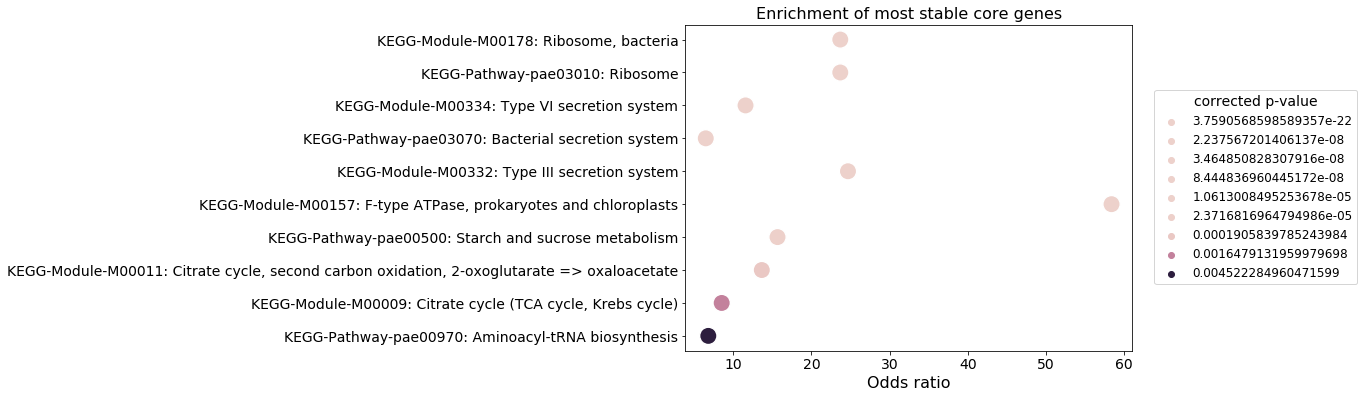

In [12]:
# Plot top most stable
pao1_most_stable_enrichment_top = pao1_most_stable_enrichment.sort_values(
    by="corrected p-value"
).head(10)
# pval_lst = list(
# pao1_most_stable_enrichment_top.sort_values(by="corrected p-value", ascending=False)["corrected p-value"])

plt.figure(figsize=(8, 6))
f = sns.scatterplot(
    data=pao1_most_stable_enrichment_top,
    x="odds ratio",
    y="enriched KEGG pathway",
    s=300,
    # size="corrected p-value",
    hue="corrected p-value",
    # hue_order=pval_lst,
    # size_order=pval_lst,
    # sizes=(100, 10),
    legend="full",
)
plt.legend(
    title="corrected p-value",
    title_fontsize=14,
    fontsize=12,
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left",
    borderaxespad=0,
)

f.set_title("Enrichment of most stable core genes", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
f.set_xlabel("Odds ratio", fontsize=16)
f.set_ylabel("")

Text(0, 0.5, '')

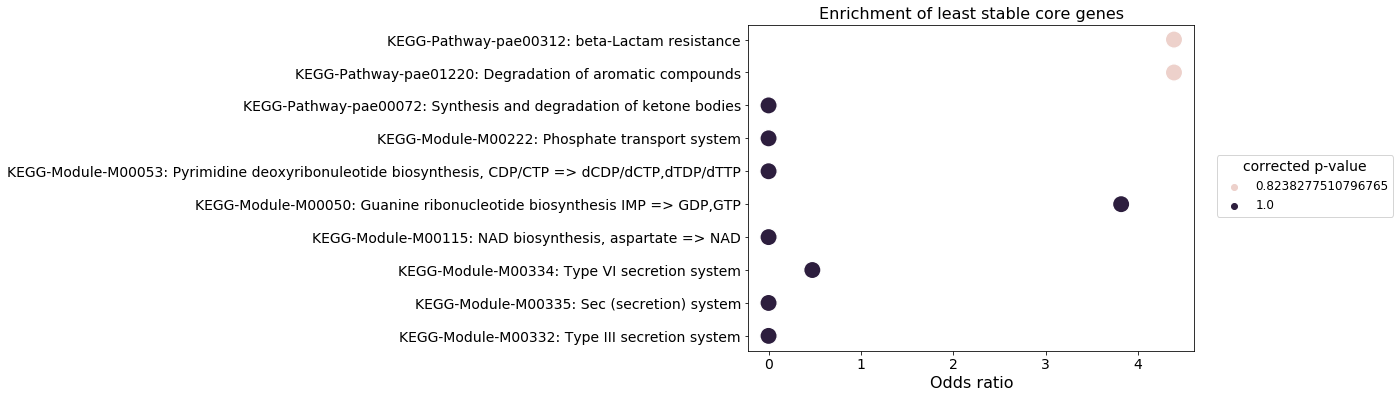

In [13]:
# Plot top most stable
pao1_least_stable_enrichment_top = pao1_least_stable_enrichment.sort_values(
    by="corrected p-value"
).head(10)
plt.figure(figsize=(8, 6))
g = sns.scatterplot(
    data=pao1_least_stable_enrichment_top,
    x="odds ratio",
    y="enriched KEGG pathway",
    s=300,
    # size="corrected p-value",
    hue="corrected p-value",
    # hue_order=pval_lst,
    # size_order=pval_lst,
    # sizes=(100, 10),
    legend="full",
)
plt.legend(
    title="corrected p-value",
    title_fontsize=14,
    fontsize=12,
    bbox_to_anchor=(1.05, 0.6),
    loc="upper left",
    borderaxespad=0,
)

plt.title("Enrichment of least stable core genes", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
g.set_xlabel("Odds ratio", fontsize=16)
g.set_ylabel("")

In [14]:
# Save
pao1_most_stable_enrichment.to_csv("pao1_most_stable_enrichment_spell.tsv", sep="\t")
pao1_least_stable_enrichment.to_csv("pao1_least_stable_enrichment_spell.tsv", sep="\t")

**Takeaway:**

KEGG enrichment analysis found that stable genes were significantly associated with essential functions: ribosome, lipopolysaccharide biosynthesis, citrate cycle. However, there are also pathways like the secretion systems, which allow for inter-strain warfare, that we’d expect to vary across strains but were found to be conserved (T3SS, T6SS) - looks like most of the genes annotated as T3/6SS are related to the secretion machinery, which is conserved across strains.

There does NOT appear to be any significantly enriched KEGG pathways in the least stable core genes. However the least stable genes with the top enrichment score seem to be related to stress response

KEGG enrichment: https://docs.google.com/spreadsheets/d/1lXZZXXjZSOuQ-cMOZ9I5llIJ2OBOQBur0Spso2WN4oY/edit#gid=0